# T2. COLUMN DETECTION

## LIBRARIES

In [16]:
#IMPORT PACKAGES
import os.path
from pathlib import Path
import numpy as np
import open3d as o3d

import random as rd
import pandas as pd
import cv2
import laspy
import json
from scipy.spatial.transform import Rotation   
import copy
from datetime import datetime

import geomapi
from geomapi.nodes import *
from geomapi import utils as ut
from geomapi.utils import geometryutils as gmu
from geomapi.tools import progresstools as pt

import geomapi.tools as tl

import context
import utils as utl
import utils.t0_utils as t0
import utils.t2_utils as t2

import matplotlib.pyplot as plt


In [17]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%autoreload 2

## INPUTS

define inputs

In [19]:
path=Path(os.getcwd()).parents[2]/'data'

input_folder=path / 't1'/'test'

output_folder= path/'t2'/'inputs'
output_folder.mkdir(parents=True, exist_ok=True)
json_file = output_folder / 'image_information.json'


results_folder = path/'t2'/'test'
results_folder.mkdir(parents=True, exist_ok=True)
pixel_resolution = 0.02  # 2 cm per pixel

#column filtering
threshold_inference=0.02#detection rate
threshold_distance_min=4#m
threshold_distance_max=15#m
threshold_angle=0.995#cosine of angle
threshold_point_count=20000
# threshold_height_ratio=0.5# #ratio of points between the center 50% and the top and bottom 25% of the bounding box
threshold_confidence=0.5
threshold_grid=0.4
threshol_uv_dimensions=0.6
threshold_dimensions=1.5 #max X,Y dimensions of clumns


weight_threshold_confidence=2.5/10
weight_threshold_grid=4.5/10
weight_threshold_point_count=3/10
# weight_threshold_height_ratio=Nan
# weight_threshold_uv_dim=Nan

threshold_score=0.4

load model

In [20]:
from roboflow import Roboflow
rf = Roboflow(api_key="MnzO68xYNrI0AgdgfS89") #api key to public model
project = rf.workspace().project("columns1")
model = project.version('1').model

loading Roboflow workspace...
loading Roboflow project...


## CREATE ORTHO IMAGERY OF PCD

load point cloud and produce ortho images

In [21]:
files=[f for f in utl.get_list_of_files(input_folder, '.laz') if 'small' in f]
print(len(files))   

7


In [22]:
data = {}
for f in files:
    #read pcd
    print(f)
    las=laspy.read(f)
    #create top view image
    image, offset_x, offset_y, pixel_resolution=t2.create_top_view_point_cloud_image(las, pixel_resolution=0.02)
    
    #store a json with the offset and the pixel resolution for every image that we proces
    data[ut.get_filename(f)] = {
    'offset_x': offset_x,
    'offset_y': offset_y,
    'pixel_resolution': pixel_resolution,
    'x':[las.x.min(),las.x.max()],
    'y':[las.y.min(),las.y.max()],
    'z':[las.z.min(),las.z.max()]
    }
    image_path = output_folder / f'{ut.get_filename(f)}.png'
    cv2.imwrite(str(image_path), image)
    
    
#write json with image information
with open(json_file, 'w') as f:
    json.dump(data, f,indent=4)

c:/Users/u0094523/OneDrive - KU Leuven/2024-05 CVPR scan-to-BIM challenge/data/t1/test/08_ShortOffice_01_F1_small_pred.laz
Function create_top_view_point_cloud_image took 5.9813 seconds to execute.
c:/Users/u0094523/OneDrive - KU Leuven/2024-05 CVPR scan-to-BIM challenge/data/t1/test/08_ShortOffice_01_F2_small_pred.laz
Function create_top_view_point_cloud_image took 2.8711 seconds to execute.
c:/Users/u0094523/OneDrive - KU Leuven/2024-05 CVPR scan-to-BIM challenge/data/t1/test/11_MedOffice_05_F2_small_pred.laz
Function create_top_view_point_cloud_image took 8.8421 seconds to execute.
c:/Users/u0094523/OneDrive - KU Leuven/2024-05 CVPR scan-to-BIM challenge/data/t1/test/11_MedOffice_05_F4_small_pred.laz
Function create_top_view_point_cloud_image took 8.0210 seconds to execute.
c:/Users/u0094523/OneDrive - KU Leuven/2024-05 CVPR scan-to-BIM challenge/data/t1/test/25_Parking_01_F1_small_pred.laz
Function create_top_view_point_cloud_image took 3.3364 seconds to execute.
c:/Users/u0094523/

In [23]:
# #plot an image using matplotlib
# plt.imshow(image)
# plt.show()

## INFERENCE

(upload produced imagery to roboflow to train the model some more)

load images

In [24]:
#load images and their information
image_files=[f for f in utl.get_list_of_files(output_folder, '.png') ]
with open(json_file, 'r') as file: image_json = json.load(file)

imageNodes=[]
for f in image_files:
    #cv 2 read image
    image = cv2.imread(str(f))
    n=ImageNode(resource=image, 
                name=ut.get_filename(f))
    
    #retrieve the image information matching the file_name
    image_information = next((v for k,v in image_json.items() if k in f), None)
    if image_information is not None:
        n.ri=image_information['pixel_resolution']
        n.xi=image_information['x']
        n.yi=image_information['y']
        n.zi=image_information['z']
        n.offset_x=image_information['offset_x']
        n.offset_y=image_information['offset_y']
    imageNodes.append(n)

compute inference over images

In [25]:
for n in imageNodes:
    #rescale the image to the model input size (half is fine)
    n.scale=0.7
    myimage = cv2.resize(n.resource, (0,0), fx=n.scale, fy=n.scale)

    #compute predictions
    prediction_group=model.predict(myimage, confidence=threshold_inference, overlap=30).json()
    
    # Compute the 2D location using x and y coordinates
    for prediction in prediction_group['predictions']:
        xp = prediction['x']*n.ri/n.scale
        yp = (myimage.shape[0]-prediction['y'])/n.scale*n.ri     
        # yp=   prediction['y']/n.scale_y*n.ri
        wp = prediction['width']*n.ri/n.scale
        hp = prediction['height']*n.ri/n.scale
        prediction['box']=o3d.geometry.AxisAlignedBoundingBox(min_bound=[(n.offset_x+xp-wp/2),
                                                                        (n.offset_y+yp-hp/2),
                                                                        n.zi[0]],
                                                                max_bound=[(n.offset_x+xp+wp/2),
                                                                        (n.offset_y+yp+hp/2),
                                                                        n.zi[1]])
        prediction['box'].color=[1,0,0]
    n.predictions=prediction_group['predictions']

plot the results

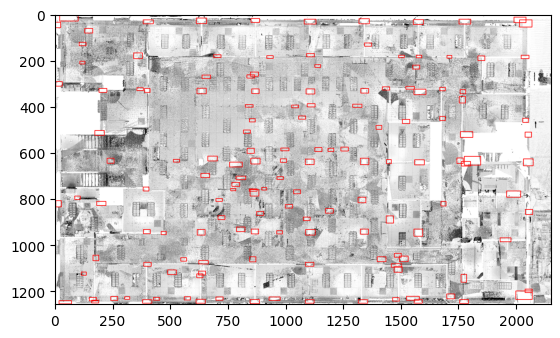

In [26]:
# n=imageNodes[0]    
#mark the detected object in the image
for n in imageNodes[0:1]:
    image=n.resource.copy()
    for prediction in n.predictions:
        x = int(prediction['x']/n.scale)
        y = int(prediction['y']/n.scale)
        width = int(prediction['width']/n.scale)
        height = int(prediction['height']/n.scale)
        cv2.rectangle(image, (int(x-width/2), int(y-height/2)), (int(x + width/2), int(y + height/2)), (255, 0, 0), 2)
    plt.imshow(image)

## FILTER THE RESULTS

processing 08_ShortOffice_01_F1_small_pred


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.9453507661819458, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.9863376915454865
confidence:0.8573851585388184, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.9643462896347046
confidence:0.7752842307090759, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.943821057677269
confidence:0.7537536025047302, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.9384384006261826


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.7508290410041809, grid score: 1, score_point_count pcd inliers: 0.82205 -> overall score: 0.8843222602510452
confidence:0.7345472574234009, grid score: 1, score_point_count pcd inliers: 0.4755 -> overall score: 0.7762868143558501
confidence:0.734350323677063, grid score: 1, score_point_count pcd inliers: 0.95765 -> overall score: 0.9208825809192657
confidence:0.7140287160873413, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.9285071790218353


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.6558099389076233, grid score: 1, score_point_count pcd inliers: 0.9857 -> overall score: 0.9096624847269057
confidence:0.6447982788085938, grid score: 1, score_point_count pcd inliers: 0.7872 -> overall score: 0.8473595697021483
confidence:0.614337146282196, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.903584286570549
confidence:0.5569300651550293, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8892325162887573


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.5507042407989502, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8876760601997375
confidence:0.5471084713935852, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8867771178483963
confidence:0.545212984085083, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8863032460212708
confidence:0.5361100435256958, grid score: 1, score_point_count pcd inliers: 0.70175 -> overall score: 0.7945525108814239
confidence:0.45960384607315063, grid score: 1, score_point_count pcd inliers: 0.7425 -> overall score: 0.7876509615182876


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.45680052042007446, grid score: 1, score_point_count pcd inliers: 0.65065 -> overall score: 0.7593951301050186
confidence:0.44668641686439514, grid score: 1, score_point_count pcd inliers: 0.7136 -> overall score: 0.7757516042160988
confidence:0.4424409866333008, grid score: 1, score_point_count pcd inliers: 0.77325 -> overall score: 0.7925852466583252
confidence:0.41606947779655457, grid score: 1, score_point_count pcd inliers: 0.4331 -> overall score: 0.6839473694491386


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.41222289204597473, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8530557230114937
confidence:0.41002893447875977, grid score: 1, score_point_count pcd inliers: 0.8417 -> overall score: 0.8050172336196899
confidence:0.3878900706768036, grid score: 0.969725176692009, score_point_count pcd inliers: 0.7618 -> overall score: 0.7618888471806049
confidence:0.3721208870410919, grid score: 0.9303022176027298, score_point_count pcd inliers: 0.23575 -> overall score: 0.5823912196815014


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.3617667257785797, grid score: 0.9044168144464493, score_point_count pcd inliers: 1 -> overall score: 0.7974292479455471
confidence:0.3413046896457672, grid score: 0.853261724114418, score_point_count pcd inliers: 0.198 -> overall score: 0.5286939482629299
confidence:0.3373810350894928, grid score: 0.843452587723732, score_point_count pcd inliers: 1 -> overall score: 0.7638989232480526
confidence:0.3322172462940216, grid score: 0.830543115735054, score_point_count pcd inliers: 0.49875 -> overall score: 0.6064237136542797
confidence:0.32743164896965027, grid score: 0.8185791224241257, score_point_count pcd inliers: 1 -> overall score: 0.7502185173332692


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.32560113072395325, grid score: 0.8140028268098831, score_point_count pcd inliers: 0.8475 -> overall score: 0.7019515547454357
confidence:0.3245340585708618, grid score: 0.8113351464271545, score_point_count pcd inliers: 0.59465 -> overall score: 0.624629330534935
confidence:0.3238781988620758, grid score: 0.8096954971551895, score_point_count pcd inliers: 0.8775 -> overall score: 0.7085825234353542
confidence:0.3023168444633484, grid score: 0.755792111158371, score_point_count pcd inliers: 0.7524 -> overall score: 0.641405661137104
confidence:0.29352712631225586, grid score: 0.7338178157806396, score_point_count pcd inliers: 0.6234 -> overall score: 0.5906197986793518
confidence:0.282438725233078, grid score: 0.706096813082695, score_point_count pcd inliers: 0.9642 -> overall score: 0.6776132471954822
confidence:0.2775411307811737, grid score: 0.6938528269529343, score_point_count pcd inliers: 0.86925 -> overall score: 0.6423940548241138
confidence:0.27571895718574524, gri

invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.2596361041069031, grid score: 0.6490902602672577, score_point_count pcd inliers: 0.19205 -> overall score: 0.4146146431469917
confidence:0.23798468708992004, grid score: 0.5949617177248001, score_point_count pcd inliers: 0.7605 -> overall score: 0.55537894474864
confidence:0.23012875020503998, grid score: 0.5753218755126, score_point_count pcd inliers: 0.08755 -> overall score: 0.34269203153192995
confidence:0.21810223162174225, grid score: 0.5452555790543556, score_point_count pcd inliers: 0.2666 -> overall score: 0.3798705684798956


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.21325863897800446, grid score: 0.5331465974450111, score_point_count pcd inliers: 0.27485 -> overall score: 0.3756856285947561
confidence:0.21160323917865753, grid score: 0.5290080979466438, score_point_count pcd inliers: 1 -> overall score: 0.5909544538706542
confidence:0.1763296127319336, grid score: 0.440824031829834, score_point_count pcd inliers: 0.9471 -> overall score: 0.5265832175064087
confidence:0.15063492953777313, grid score: 0.37658732384443283, score_point_count pcd inliers: 0.7331 -> overall score: 0.427053028114438


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.14122727513313293, grid score: 0.35306818783283234, score_point_count pcd inliers: 0.84695 -> overall score: 0.4482725033080578
confidence:0.13439500331878662, grid score: 0.33598750829696655, score_point_count pcd inliers: 1 -> overall score: 0.4847931295633316
confidence:0.12983600795269012, grid score: 0.3245900198817253, score_point_count pcd inliers: 0.6605 -> overall score: 0.3766745109349489
confidence:0.11987990140914917, grid score: 0.2996997535228729, score_point_count pcd inliers: 0.4939 -> overall score: 0.31300486443758013


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.11806833744049072, grid score: 0.2951708436012268, score_point_count pcd inliers: 0.7142 -> overall score: 0.37660396398067475
confidence:0.11792613565921783, grid score: 0.2948153391480446, score_point_count pcd inliers: 0.26515 -> overall score: 0.2416934365314245
confidence:0.11748860031366348, grid score: 0.2937215007841587, score_point_count pcd inliers: 0.3126 -> overall score: 0.25532682543128726
confidence:0.1146412044763565, grid score: 0.28660301119089127, score_point_count pcd inliers: 0.16475 -> overall score: 0.2070566561549902


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.10902182757854462, grid score: 0.27255456894636154, score_point_count pcd inliers: 0.403 -> overall score: 0.27080501292049886
confidence:0.10870420932769775, grid score: 0.2717605233192444, score_point_count pcd inliers: 0.46145 -> overall score: 0.2879032878255844
confidence:0.10679668188095093, grid score: 0.2669917047023773, score_point_count pcd inliers: 1 -> overall score: 0.4468454375863075
confidence:0.10568775236606598, grid score: 0.26421938091516495, score_point_count pcd inliers: 0.03845 -> overall score: 0.1568556595033407
confidence:0.10501553863286972, grid score: 0.2625388465821743, score_point_count pcd inliers: 0.20865 -> overall score: 0.20699136562019588


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.10398632287979126, grid score: 0.25996580719947815, score_point_count pcd inliers: 0.4732 -> overall score: 0.28494119395971296
confidence:0.10069715976715088, grid score: 0.2517428994178772, score_point_count pcd inliers: 0.0762 -> overall score: 0.16131859467983245
confidence:0.1005515530705452, grid score: 0.251378882676363, score_point_count pcd inliers: 0.19375 -> overall score: 0.19638338547199963
confidence:0.0970076471567154, grid score: 0.24251911789178848, score_point_count pcd inliers: 0.79005 -> overall score: 0.37040051484048364
confidence:0.09648790210485458, grid score: 0.24121975526213646, score_point_count pcd inliers: 1 -> overall score: 0.43267086539417504


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.0952112004160881, grid score: 0.23802800104022026, score_point_count pcd inliers: 0.6242 -> overall score: 0.3181754005721211
confidence:0.09385872632265091, grid score: 0.23464681580662727, score_point_count pcd inliers: 0.3386 -> overall score: 0.230635748693645
confidence:0.09135691076517105, grid score: 0.22839227691292763, score_point_count pcd inliers: 0.38995 -> overall score: 0.2426007523021102
confidence:0.09084246307611465, grid score: 0.22710615769028664, score_point_count pcd inliers: 0.16705 -> overall score: 0.17502338672965764
confidence:0.09015297889709473, grid score: 0.22538244724273682, score_point_count pcd inliers: 0.3115 -> overall score: 0.21741034598350523


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.08582931756973267, grid score: 0.21457329392433167, score_point_count pcd inliers: 0.86995 -> overall score: 0.3790003116583824
confidence:0.08565227687358856, grid score: 0.2141306921839714, score_point_count pcd inliers: 0.6945 -> overall score: 0.3261218807011843
confidence:0.08278121799230576, grid score: 0.2069530449807644, score_point_count pcd inliers: 0.8855 -> overall score: 0.3794741747394204
confidence:0.08132238686084747, grid score: 0.20330596715211868, score_point_count pcd inliers: 0.978 -> overall score: 0.40521828193366527
confidence:0.07975365221500397, grid score: 0.19938413053750992, score_point_count pcd inliers: 0.44575 -> overall score: 0.24338627179563044
confidence:0.07909674197435379, grid score: 0.19774185493588448, score_point_count pcd inliers: 0.37505 -> overall score: 0.22127302021473644


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.07620838284492493, grid score: 0.19052095711231232, score_point_count pcd inliers: 0.8203 -> overall score: 0.3508765264117718
confidence:0.07507476210594177, grid score: 0.18768690526485443, score_point_count pcd inliers: 1 -> overall score: 0.4032277978956699
confidence:0.0723256915807724, grid score: 0.180814228951931, score_point_count pcd inliers: 0.5322 -> overall score: 0.2591078259235621
confidence:0.07001271843910217, grid score: 0.17503179609775543, score_point_count pcd inliers: 1 -> overall score: 0.0


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.0692320168018341, grid score: 0.17308004200458527, score_point_count pcd inliers: 0.48235 -> overall score: 0.2398990231025219
confidence:0.06746457517147064, grid score: 0.1686614379286766, score_point_count pcd inliers: 0.52405 -> overall score: 0.24997879086077213
confidence:0.06583899259567261, grid score: 0.16459748148918152, score_point_count pcd inliers: 0.47365 -> overall score: 0.23262361481904983
confidence:0.06487328559160233, grid score: 0.1621832139790058, score_point_count pcd inliers: 0.84325 -> overall score: 0.3421757676884532
confidence:0.06431291997432709, grid score: 0.16078229993581772, score_point_count pcd inliers: 0.2061 -> overall score: 0.15026026496469974


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.06424175947904587, grid score: 0.16060439869761467, score_point_count pcd inliers: 0.27025 -> overall score: 0.16940741928368808
confidence:0.06310994923114777, grid score: 0.15777487307786942, score_point_count pcd inliers: 0.9572 -> overall score: 0.3739361801928282
confidence:0.06157088279724121, grid score: 0.15392720699310303, score_point_count pcd inliers: 0.2095 -> overall score: 0.14750996384620665
confidence:0.05944221839308739, grid score: 0.14860554598271847, score_point_count pcd inliers: 0.6129 -> overall score: 0.26560305029049514


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.057050514966249466, grid score: 0.14262628741562366, score_point_count pcd inliers: 0.2283 -> overall score: 0.146934458078593
confidence:0.056753821671009064, grid score: 0.14188455417752266, score_point_count pcd inliers: 0.1269 -> overall score: 0.11610650479763746
confidence:0.05511186271905899, grid score: 0.13777965679764748, score_point_count pcd inliers: 0.78825 -> overall score: 0.3122538112387061
confidence:0.054886411875486374, grid score: 0.13721602968871593, score_point_count pcd inliers: 1 -> overall score: 0.37546881632879375
confidence:0.05428266525268555, grid score: 0.13570666313171387, score_point_count pcd inliers: 0.87985 -> overall score: 0.3385936647224426


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.053826361894607544, grid score: 0.13456590473651886, score_point_count pcd inliers: 1 -> overall score: 0.37401124760508536
confidence:0.05349663272500038, grid score: 0.13374158181250095, score_point_count pcd inliers: 0.3812 -> overall score: 0.18791786999687551
confidence:0.053142860531806946, grid score: 0.13285715132951736, score_point_count pcd inliers: 0.1875 -> overall score: 0.12932143323123454
confidence:0.05238158255815506, grid score: 0.13095395639538765, score_point_count pcd inliers: 1 -> overall score: 0.3720246760174632


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.051931366324424744, grid score: 0.12982841581106186, score_point_count pcd inliers: 0.8774 -> overall score: 0.334625628696084
confidence:0.0515335351228714, grid score: 0.1288338378071785, score_point_count pcd inliers: 1 -> overall score: 0.37085861079394816
confidence:0.051297131925821304, grid score: 0.12824282981455326, score_point_count pcd inliers: 0.20105 -> overall score: 0.1308485563980043
confidence:0.04854559525847435, grid score: 0.12136398814618587, score_point_count pcd inliers: 0.47365 -> overall score: 0.20884519348040223


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.04845224320888519, grid score: 0.12113060802221298, score_point_count pcd inliers: 0.46025 -> overall score: 0.20469683441221714
confidence:0.04828251898288727, grid score: 0.12070629745721817, score_point_count pcd inliers: 0.667 -> overall score: 0.26648846360147
confidence:0.0470358245074749, grid score: 0.11758956126868725, score_point_count pcd inliers: 0.1308 -> overall score: 0.10391425869777798
confidence:0.046994648873806, grid score: 0.117486622184515, score_point_count pcd inliers: 0.61755 -> overall score: 0.24988264220148326


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.04607412964105606, grid score: 0.11518532410264015, score_point_count pcd inliers: 0.749 -> overall score: 0.2880519282564521
confidence:0.045388612896203995, grid score: 0.11347153224050999, score_point_count pcd inliers: 0.62625 -> overall score: 0.2502843427322805
confidence:0.04494546353816986, grid score: 0.11236365884542465, score_point_count pcd inliers: 0.2625 -> overall score: 0.14055001236498355
confidence:0.043767694383859634, grid score: 0.10941923595964909, score_point_count pcd inliers: 0.1627 -> overall score: 0.10899057977780699
confidence:0.042953524738550186, grid score: 0.10738381184637547, score_point_count pcd inliers: 0.62425 -> overall score: 0.2463360965155065
confidence:0.04218698665499687, grid score: 0.10546746663749218, score_point_count pcd inliers: 0.5447 -> overall score: 0.22141710665062067


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.042003314942121506, grid score: 0.10500828735530376, score_point_count pcd inliers: 0.59165 -> overall score: 0.23524955804541706
confidence:0.041632845997810364, grid score: 0.10408211499452591, score_point_count pcd inliers: 0.1517 -> overall score: 0.10275516324698925
confidence:0.04003620892763138, grid score: 0.10009052231907845, score_point_count pcd inliers: 0.15195 -> overall score: 0.10063478727549315
confidence:0.03793345391750336, grid score: 0.09483363479375839, score_point_count pcd inliers: 0.55755 -> overall score: 0.2194234991365671


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.03778120502829552, grid score: 0.09445301257073879, score_point_count pcd inliers: 0.25565 -> overall score: 0.12864415691390635
confidence:0.03676178306341171, grid score: 0.09190445765852928, score_point_count pcd inliers: 0.17055 -> overall score: 0.10171245171219111
confidence:0.035461824387311935, grid score: 0.08865456096827984, score_point_count pcd inliers: 1 -> overall score: 0.3487600085325539


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.035177070647478104, grid score: 0.08794267661869526, score_point_count pcd inliers: 0.6217 -> overall score: 0.2348784721402824
confidence:0.035023484379053116, grid score: 0.08755871094763279, score_point_count pcd inliers: 1 -> overall score: 0.348157291021198
confidence:0.034978486597537994, grid score: 0.08744621649384499, score_point_count pcd inliers: 0.3798 -> overall score: 0.16203541907161473
confidence:0.03282153606414795, grid score: 0.08205384016036987, score_point_count pcd inliers: 1 -> overall score: 0.3451296120882034


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.03271479904651642, grid score: 0.08178699761629105, score_point_count pcd inliers: 0.6797 -> overall score: 0.24889284868896006
confidence:0.03256942331790924, grid score: 0.0814235582947731, score_point_count pcd inliers: 0.48095 -> overall score: 0.1890679570621252
confidence:0.03241197019815445, grid score: 0.08102992549538612, score_point_count pcd inliers: 0.2647 -> overall score: 0.12397645902246236
confidence:0.032364968210458755, grid score: 0.08091242052614689, score_point_count pcd inliers: 1 -> overall score: 0.3445018312893808


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.03220267593860626, grid score: 0.08050668984651566, score_point_count pcd inliers: 0.6227 -> overall score: 0.23108867941558361
confidence:0.03163886070251465, grid score: 0.07909715175628662, score_point_count pcd inliers: 0.57925 -> overall score: 0.21727843346595765
confidence:0.03103734739124775, grid score: 0.07759336847811937, score_point_count pcd inliers: 0.192 -> overall score: 0.10027635266296565
confidence:0.030397744849324226, grid score: 0.07599436212331057, score_point_count pcd inliers: 0.22965 -> overall score: 0.11069189916782081


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.030192246660590172, grid score: 0.07548061665147543, score_point_count pcd inliers: 0.2336 -> overall score: 0.11159433915831149
confidence:0.030165383592247963, grid score: 0.07541345898061991, score_point_count pcd inliers: 0.3298 -> overall score: 0.14041740243934092
confidence:0.02991671673953533, grid score: 0.07479179184883833, score_point_count pcd inliers: 0.35335 -> overall score: 0.1471404855168611
confidence:0.02874913439154625, grid score: 0.07187283597886562, score_point_count pcd inliers: 0.63165 -> overall score: 0.2290250597883761


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.027893688529729843, grid score: 0.06973422132432461, score_point_count pcd inliers: 0.96075 -> overall score: 0.32657882172837854
confidence:0.027242299169301987, grid score: 0.06810574792325497, score_point_count pcd inliers: 0.3447 -> overall score: 0.14086816135779023
confidence:0.026993684470653534, grid score: 0.06748421117663383, score_point_count pcd inliers: 0.44605 -> overall score: 0.1709313161471486
confidence:0.026712024584412575, grid score: 0.06678006146103144, score_point_count pcd inliers: 1 -> overall score: 0.3367290338035673


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.026525018736720085, grid score: 0.06631254684180021, score_point_count pcd inliers: 0.21075 -> overall score: 0.0996969007629901
confidence:0.025621512904763222, grid score: 0.06405378226190805, score_point_count pcd inliers: 0.48 -> overall score: 0.17922958024404942
confidence:0.025525275617837906, grid score: 0.06381318904459476, score_point_count pcd inliers: 0.17475 -> overall score: 0.08752225397452712
confidence:0.025131814181804657, grid score: 0.06282953545451164, score_point_count pcd inliers: 0.5582 -> overall score: 0.2020162444999814


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.02185666374862194, grid score: 0.05464165937155485, score_point_count pcd inliers: 0.2065 -> overall score: 0.09200291265435516
confidence:0.021269025281071663, grid score: 0.05317256320267916, score_point_count pcd inliers: 0.5146 -> overall score: 0.18362490976147353
confidence:0.020999182015657425, grid score: 0.05249795503914356, score_point_count pcd inliers: 0.79165 -> overall score: 0.26636887527152897
confidence:0.020746827125549316, grid score: 0.05186706781387329, score_point_count pcd inliers: 0.6784 -> overall score: 0.23204688729763032


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.020441798493266106, grid score: 0.051104496233165264, score_point_count pcd inliers: 0.2429 -> overall score: 0.1009774729282409
processing 08_ShortOffice_01_F2_small_pred


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.772736668586731, grid score: 1, score_point_count pcd inliers: 0.9659 -> overall score: 0.9329541671466827
confidence:0.7376822829246521, grid score: 1, score_point_count pcd inliers: 0.29755 -> overall score: 0.723685570731163
confidence:0.713585615158081, grid score: 1, score_point_count pcd inliers: 0.27165 -> overall score: 0.7098914037895202


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.6984648704528809, grid score: 1, score_point_count pcd inliers: 0.9743 -> overall score: 0.9169062176132201
confidence:0.6829198598861694, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.9207299649715424
confidence:0.6467161774635315, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.9116790443658829
confidence:0.6149636507034302, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.9037409126758575


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.5826030373573303, grid score: 1, score_point_count pcd inliers: 0.43385 -> overall score: 0.7258057593393326
confidence:0.5740798711776733, grid score: 1, score_point_count pcd inliers: 0.8606 -> overall score: 0.8516999677944184
confidence:0.5341845750808716, grid score: 1, score_point_count pcd inliers: 0.71345 -> overall score: 0.7975811437702178
confidence:0.5284669399261475, grid score: 1, score_point_count pcd inliers: 0.56745 -> overall score: 0.7523517349815368


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.4898335635662079, grid score: 1, score_point_count pcd inliers: 0.28645 -> overall score: 0.6583933908915519
confidence:0.4583083391189575, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8645770847797394
confidence:0.45547446608543396, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8638686165213585
confidence:0.4526483416557312, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8631620854139328
confidence:0.44063884019851685, grid score: 1, score_point_count pcd inliers: 0.5354 -> overall score: 0.7207797100496292
confidence:0.4206881523132324, grid score: 1, score_point_count pcd inliers: 0.91185 -> overall score: 0.828727038078308
confidence:0.39942467212677, grid score: 0.998561680316925, score_point_count pcd inliers: 1 -> overall score: 0.0
confidence:0.3900390565395355, grid score: 0.9750976413488388, score_point_count pcd inliers: 0.3712 -> overall score: 0.6476637027418614


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.3886711001396179, grid score: 0.9716777503490448, score_point_count pcd inliers: 1 -> overall score: 0.8344227626919747
confidence:0.38855263590812683, grid score: 0.9713815897703171, score_point_count pcd inliers: 0.7287 -> overall score: 0.7528698743736744
confidence:0.3792548179626465, grid score: 0.9481370449066162, score_point_count pcd inliers: 0.5939 -> overall score: 0.6996453746986389


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.3674154579639435, grid score: 0.9185386449098587, score_point_count pcd inliers: 0.8242 -> overall score: 0.7524562547004223
confidence:0.36015284061431885, grid score: 0.9003821015357971, score_point_count pcd inliers: 0.84965 -> overall score: 0.7501051558446884
confidence:0.32929542660713196, grid score: 0.8232385665178299, score_point_count pcd inliers: 0.7729 -> overall score: 0.6846512115848065


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.321759968996048, grid score: 0.8043999224901199, score_point_count pcd inliers: 0.72765 -> overall score: 0.660714957369566
confidence:0.29017210006713867, grid score: 0.7254302501678467, score_point_count pcd inliers: 1 -> overall score: 0.6989866375923157
confidence:0.2850213050842285, grid score: 0.7125532627105713, score_point_count pcd inliers: 0.6449 -> overall score: 0.5853742944908142


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.27828875184059143, grid score: 0.6957218796014786, score_point_count pcd inliers: 0.87165 -> overall score: 0.6441420337808133
confidence:0.2601553499698639, grid score: 0.6503883749246597, score_point_count pcd inliers: 0.7732 -> overall score: 0.5896736062085628
confidence:0.2496703863143921, grid score: 0.6241759657859802, score_point_count pcd inliers: 1 -> overall score: 0.6432967811822892
confidence:0.24470935761928558, grid score: 0.611773394048214, score_point_count pcd inliers: 0.75875 -> overall score: 0.5641003667265176


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.23669414222240448, grid score: 0.5917353555560112, score_point_count pcd inliers: 0.69675 -> overall score: 0.5344794455558062
confidence:0.23264478147029877, grid score: 0.5816119536757469, score_point_count pcd inliers: 0.3152 -> overall score: 0.4144465745216608
confidence:0.2199028730392456, grid score: 0.549757182598114, score_point_count pcd inliers: 0.6013 -> overall score: 0.48275645042896265


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.19723087549209595, grid score: 0.49307718873023987, score_point_count pcd inliers: 0.8591 -> overall score: 0.5289224538016319
confidence:0.19079461693763733, grid score: 0.4769865423440933, score_point_count pcd inliers: 1 -> overall score: 0.5623425982892514
confidence:0.18540658056735992, grid score: 0.4635164514183998, score_point_count pcd inliers: 1 -> overall score: 0.5549340482801199


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.17846770584583282, grid score: 0.44616926461458206, score_point_count pcd inliers: 1 -> overall score: 0.5453930955380202
confidence:0.17198298871517181, grid score: 0.42995747178792953, score_point_count pcd inliers: 0.4849 -> overall score: 0.38194660948336123
confidence:0.1594037562608719, grid score: 0.3985093906521797, score_point_count pcd inliers: 0.51065 -> overall score: 0.3723751648586988


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.15321394801139832, grid score: 0.3830348700284958, score_point_count pcd inliers: 0.40185 -> overall score: 0.33122417851567265
confidence:0.14787302911281586, grid score: 0.36968257278203964, score_point_count pcd inliers: 0.30245 -> overall score: 0.2940604150301218
confidence:0.1456587314605713, grid score: 0.3641468286514282, score_point_count pcd inliers: 0.34705 -> overall score: 0.30439575575828554
confidence:0.1442263126373291, grid score: 0.36056578159332275, score_point_count pcd inliers: 0.24595 -> overall score: 0.2720961798763275
confidence:0.14333587884902954, grid score: 0.35833969712257385, score_point_count pcd inliers: 0.9532 -> overall score: 0.4830468334174156


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.14313127100467682, grid score: 0.35782817751169205, score_point_count pcd inliers: 0.8979 -> overall score: 0.4661754976314306
confidence:0.1407296061515808, grid score: 0.351824015378952, score_point_count pcd inliers: 0.9677 -> overall score: 0.4838132084584236
confidence:0.13630402088165283, grid score: 0.3407600522041321, score_point_count pcd inliers: 0.3817 -> overall score: 0.30192802871227264
confidence:0.13314072787761688, grid score: 0.3328518196940422, score_point_count pcd inliers: 0.2247 -> overall score: 0.2504785008317232
confidence:0.13036641478538513, grid score: 0.32591603696346283, score_point_count pcd inliers: 0.3202 -> overall score: 0.27531382032990454


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.12626105546951294, grid score: 0.31565263867378235, score_point_count pcd inliers: 0.5015 -> overall score: 0.32405895127058026
confidence:0.1249992847442627, grid score: 0.31249821186065674, score_point_count pcd inliers: 0.15685 -> overall score: 0.2189290165233612
confidence:0.12417805194854736, grid score: 0.3104451298713684, score_point_count pcd inliers: 0.67615 -> overall score: 0.3735898214292526
confidence:0.12257932126522064, grid score: 0.3064483031630516, score_point_count pcd inliers: 1 -> overall score: 0.46854656673967837
confidence:0.11752541363239288, grid score: 0.2938135340809822, score_point_count pcd inliers: 0.63595 -> overall score: 0.3523824437445402


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.11661148071289062, grid score: 0.29152870178222656, score_point_count pcd inliers: 1 -> overall score: 0.4603407859802246
confidence:0.11633477360010147, grid score: 0.2908369340002537, score_point_count pcd inliers: 0.3627 -> overall score: 0.26877031370013954
confidence:0.11552948504686356, grid score: 0.2888237126171589, score_point_count pcd inliers: 1 -> overall score: 0.4588530419394374
confidence:0.11008743941783905, grid score: 0.2752185985445976, score_point_count pcd inliers: 0.7948 -> overall score: 0.3898102291995287


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.1083543673157692, grid score: 0.270885918289423, score_point_count pcd inliers: 0.815 -> overall score: 0.3934872550591826
confidence:0.1081632599234581, grid score: 0.27040814980864525, score_point_count pcd inliers: 0.6489 -> overall score: 0.3433944823947549
confidence:0.10376573354005814, grid score: 0.25941433385014534, score_point_count pcd inliers: 0.7656 -> overall score: 0.37235788361757993
confidence:0.10285812616348267, grid score: 0.25714531540870667, score_point_count pcd inliers: 0.8473 -> overall score: 0.3956199234747887


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.09986589848995209, grid score: 0.24966474622488022, score_point_count pcd inliers: 0.88505 -> overall score: 0.4028306104236841
confidence:0.09734506905078888, grid score: 0.2433626726269722, score_point_count pcd inliers: 0.5831 -> overall score: 0.3087794699448347
confidence:0.0969797745347023, grid score: 0.24244943633675575, score_point_count pcd inliers: 0.5398 -> overall score: 0.29528718998521564


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.09533832967281342, grid score: 0.23834582418203354, score_point_count pcd inliers: 0.8162 -> overall score: 0.3759502033001184
confidence:0.09395492076873779, grid score: 0.23488730192184448, score_point_count pcd inliers: 1 -> overall score: 0.42918801605701445
confidence:0.09026822447776794, grid score: 0.22567056119441986, score_point_count pcd inliers: 0.3114 -> overall score: 0.21753880865693093
confidence:0.08857061713933945, grid score: 0.22142654284834862, score_point_count pcd inliers: 0.71145 -> overall score: 0.3352195985665918


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.08842891454696655, grid score: 0.22107228636741638, score_point_count pcd inliers: 0.18735 -> overall score: 0.17779475750207901
confidence:0.08522432297468185, grid score: 0.21306080743670464, score_point_count pcd inliers: 0.35885 -> overall score: 0.22483844409018755
confidence:0.08485569804906845, grid score: 0.21213924512267113, score_point_count pcd inliers: 0.43005 -> overall score: 0.2456915848174691


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.08191896229982376, grid score: 0.2047974057495594, score_point_count pcd inliers: 1 -> overall score: 0.41263857316225766
confidence:0.0806930884718895, grid score: 0.20173272117972374, score_point_count pcd inliers: 0.18795 -> overall score: 0.16733799664884805
confidence:0.08055078983306885, grid score: 0.20137697458267212, score_point_count pcd inliers: 0.55405 -> overall score: 0.27697233602046967
confidence:0.07929401099681854, grid score: 0.19823502749204636, score_point_count pcd inliers: 0.9072 -> overall score: 0.3811892651206255


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.07829715311527252, grid score: 0.1957428827881813, score_point_count pcd inliers: 1 -> overall score: 0.4076585855334997
confidence:0.07678616791963577, grid score: 0.19196541979908943, score_point_count pcd inliers: 0.50775 -> overall score: 0.25790598088949923
confidence:0.07434052973985672, grid score: 0.1858513243496418, score_point_count pcd inliers: 0.1313 -> overall score: 0.141608228392303
confidence:0.07432250678539276, grid score: 0.1858062669634819, score_point_count pcd inliers: 0.6684 -> overall score: 0.3027134468299151
confidence:0.07111624628305435, grid score: 0.17779061570763588, score_point_count pcd inliers: 0.2006 -> overall score: 0.15796483863919974


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.070383720099926, grid score: 0.175959300249815, score_point_count pcd inliers: 0.5273 -> overall score: 0.25496761513739824
confidence:0.06970703601837158, grid score: 0.17426759004592896, score_point_count pcd inliers: 0.7619 -> overall score: 0.3244171745252609
confidence:0.06817667931318283, grid score: 0.17044169828295708, score_point_count pcd inliers: 0.31695 -> overall score: 0.1888279340556264
confidence:0.06646829098463058, grid score: 0.16617072746157646, score_point_count pcd inliers: 0.5582 -> overall score: 0.25885390010386705


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.06596790254116058, grid score: 0.16491975635290146, score_point_count pcd inliers: 0.1866 -> overall score: 0.1466858659940958
confidence:0.06524667888879776, grid score: 0.1631166972219944, score_point_count pcd inliers: 0.93445 -> overall score: 0.3700491834720969
confidence:0.06472793966531754, grid score: 0.16181984916329384, score_point_count pcd inliers: 0.81 -> overall score: 0.3320009170398116
confidence:0.06372903287410736, grid score: 0.1593225821852684, score_point_count pcd inliers: 0.6268 -> overall score: 0.2756674202018976


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.06066202372312546, grid score: 0.15165505930781364, score_point_count pcd inliers: 0.61255 -> overall score: 0.2671752826192975
confidence:0.059996701776981354, grid score: 0.14999175444245338, score_point_count pcd inliers: 0.44585 -> overall score: 0.21625046494334937
confidence:0.05896030738949776, grid score: 0.1474007684737444, score_point_count pcd inliers: 0.6095 -> overall score: 0.26392042266055943
confidence:0.05870012566447258, grid score: 0.14675031416118145, score_point_count pcd inliers: 0.2828 -> overall score: 0.1655526727886498
confidence:0.05670912563800812, grid score: 0.1417728140950203, score_point_count pcd inliers: 0.5635 -> overall score: 0.24702504775226117
confidence:0.05642494559288025, grid score: 0.14106236398220062, score_point_count pcd inliers: 1 -> overall score: 0.37758430019021033
confidence:0.05636806786060333, grid score: 0.14092016965150833, score_point_count pcd inliers: 0.19235 -> overall score: 0.1352110933083296


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.05625315010547638, grid score: 0.14063287526369095, score_point_count pcd inliers: 0.44615 -> overall score: 0.21119308139503
confidence:0.05396305397152901, grid score: 0.13490763492882252, score_point_count pcd inliers: 0.55125 -> overall score: 0.23957419921085238
confidence:0.05205812677741051, grid score: 0.13014531694352627, score_point_count pcd inliers: 0.3801 -> overall score: 0.18560992431893944
confidence:0.05113634094595909, grid score: 0.12784085236489773, score_point_count pcd inliers: 0.1741 -> overall score: 0.12254246880069375


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.0506933219730854, grid score: 0.1267333049327135, score_point_count pcd inliers: 0.74665 -> overall score: 0.29369831771299243
confidence:0.04996228963136673, grid score: 0.12490572407841682, score_point_count pcd inliers: 0.23925 -> overall score: 0.14047314824312923
confidence:0.049644265323877335, grid score: 0.12411066330969334, score_point_count pcd inliers: 0.73125 -> overall score: 0.2876358648203313
confidence:0.0480230450630188, grid score: 0.120057612657547, score_point_count pcd inliers: 1 -> overall score: 0.36603168696165084


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.046490129083395004, grid score: 0.11622532270848751, score_point_count pcd inliers: 0.6898 -> overall score: 0.27086392748966814
confidence:0.04648394510149956, grid score: 0.1162098627537489, score_point_count pcd inliers: 0.04795 -> overall score: 0.07830042451456189
confidence:0.04639344662427902, grid score: 0.11598361656069756, score_point_count pcd inliers: 1 -> overall score: 0.36379098910838364
confidence:0.04494734853506088, grid score: 0.1123683713376522, score_point_count pcd inliers: 0.38775 -> overall score: 0.1781276042357087
confidence:0.04428346827626228, grid score: 0.11070867069065571, score_point_count pcd inliers: 0.7396 -> overall score: 0.2827697688798606


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.04367866367101669, grid score: 0.10919665917754173, score_point_count pcd inliers: 0.976 -> overall score: 0.35285816254764796
confidence:0.04315393045544624, grid score: 0.10788482613861561, score_point_count pcd inliers: 0.2583 -> overall score: 0.1368266543762386
confidence:0.042476680129766464, grid score: 0.10619170032441616, score_point_count pcd inliers: 0.57945 -> overall score: 0.23224043517842888
confidence:0.041394200176000595, grid score: 0.10348550044000149, score_point_count pcd inliers: 0.06495 -> overall score: 0.07640202524200082


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.03999953344464302, grid score: 0.09999883361160755, score_point_count pcd inliers: 0.4221 -> overall score: 0.18162935848638415
confidence:0.03983990103006363, grid score: 0.09959975257515907, score_point_count pcd inliers: 0.12995 -> overall score: 0.09376486391633748
confidence:0.03977516293525696, grid score: 0.0994379073381424, score_point_count pcd inliers: 0.9129 -> overall score: 0.3285608490359783
confidence:0.03952978551387787, grid score: 0.09882446378469467, score_point_count pcd inliers: 1 -> overall score: 0.35435345508158206


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.03932872787117958, grid score: 0.09832181967794895, score_point_count pcd inliers: 0.3793 -> overall score: 0.16786700082287193
confidence:0.03841615095734596, grid score: 0.0960403773933649, score_point_count pcd inliers: 0.26475 -> overall score: 0.1322472075663507
confidence:0.03695759177207947, grid score: 0.09239397943019867, score_point_count pcd inliers: 0.4144 -> overall score: 0.17513668868660925
confidence:0.03676588088274002, grid score: 0.09191470220685005, score_point_count pcd inliers: 1 -> overall score: 0.3505530862137675


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.03627731278538704, grid score: 0.0906932819634676, score_point_count pcd inliers: 0.87445 -> overall score: 0.31221630507990716
confidence:0.03596547618508339, grid score: 0.08991369046270847, score_point_count pcd inliers: 0.5307 -> overall score: 0.20866252975448965
confidence:0.03578823059797287, grid score: 0.08947057649493217, score_point_count pcd inliers: 0.3934 -> overall score: 0.1672288170722127


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.035157542675733566, grid score: 0.08789385668933392, score_point_count pcd inliers: 0.19605 -> overall score: 0.10715662117913366
confidence:0.034051064401865005, grid score: 0.08512766100466251, score_point_count pcd inliers: 1 -> overall score: 0.34682021355256437
confidence:0.03317832574248314, grid score: 0.08294581435620785, score_point_count pcd inliers: 0.1786 -> overall score: 0.09920019789591432


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.03301672264933586, grid score: 0.08254180662333965, score_point_count pcd inliers: 0.9209 -> overall score: 0.3216679936428368
confidence:0.031950026750564575, grid score: 0.07987506687641144, score_point_count pcd inliers: 0.6089 -> overall score: 0.2266012867820263
confidence:0.03115459345281124, grid score: 0.0778864836320281, score_point_count pcd inliers: 0.31935 -> overall score: 0.13864256599761546
confidence:0.03101099096238613, grid score: 0.07752747740596533, score_point_count pcd inliers: 0.561 -> overall score: 0.21094011257328094


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.03055635467171669, grid score: 0.07639088667929173, score_point_count pcd inliers: 0.57075 -> overall score: 0.21323998767361044
confidence:0.03022175468504429, grid score: 0.07555438671261072, score_point_count pcd inliers: 0.3362 -> overall score: 0.1424149126919359
confidence:0.029953520745038986, grid score: 0.07488380186259747, score_point_count pcd inliers: 0.22005 -> overall score: 0.1072010910244286


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.0287841334939003, grid score: 0.07196033373475075, score_point_count pcd inliers: 1 -> overall score: 0.0
confidence:0.028381438925862312, grid score: 0.07095359731465578, score_point_count pcd inliers: 0.6925 -> overall score: 0.24677447852306067
confidence:0.027827449142932892, grid score: 0.06956862285733223, score_point_count pcd inliers: 0.8591 -> overall score: 0.2959927425715327
confidence:0.026606298983097076, grid score: 0.06651574745774269, score_point_count pcd inliers: 1 -> overall score: 0.33658366110175847
confidence:0.026410851627588272, grid score: 0.06602712906897068, score_point_count pcd inliers: 0.47795 -> overall score: 0.17969992098793386


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.026058530434966087, grid score: 0.06514632608741522, score_point_count pcd inliers: 0.557 -> overall score: 0.20293047934807837
confidence:0.024668879806995392, grid score: 0.06167219951748848, score_point_count pcd inliers: 0.57635 -> overall score: 0.20682470973461867
confidence:0.023732051253318787, grid score: 0.05933012813329697, score_point_count pcd inliers: 1 -> overall score: 0.3326315704733133
confidence:0.02350609377026558, grid score: 0.05876523442566395, score_point_count pcd inliers: 0.27025 -> overall score: 0.11339587893411517


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.023169871419668198, grid score: 0.057924678549170494, score_point_count pcd inliers: 0.80465 -> overall score: 0.27325357320204374
confidence:0.023169061169028282, grid score: 0.057922652922570705, score_point_count pcd inliers: 0.2229 -> overall score: 0.09872745910741389
confidence:0.022882122546434402, grid score: 0.057205306366086006, score_point_count pcd inliers: 1 -> overall score: 0.3314629185013473


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.022825313732028008, grid score: 0.05706328433007002, score_point_count pcd inliers: 0.38975 -> overall score: 0.1483098063815385
confidence:0.02264518477022648, grid score: 0.056612961925566196, score_point_count pcd inliers: 0.82555 -> overall score: 0.27880212905906143
confidence:0.022574983537197113, grid score: 0.05643745884299278, score_point_count pcd inliers: 0.6226 -> overall score: 0.21782060236364603
confidence:0.022460589185357094, grid score: 0.056151472963392735, score_point_count pcd inliers: 0.81545 -> overall score: 0.275518310129866


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.022453615441918373, grid score: 0.05613403860479593, score_point_count pcd inliers: 0.1325 -> overall score: 0.07062372123263777
confidence:0.02084749937057495, grid score: 0.05211874842643738, score_point_count pcd inliers: 0.3781 -> overall score: 0.14209531163454053
confidence:0.020737221464514732, grid score: 0.05184305366128683, score_point_count pcd inliers: 0.2892 -> overall score: 0.11527367951370776
confidence:0.020608024671673775, grid score: 0.05152006167918444, score_point_count pcd inliers: 0.46175 -> overall score: 0.16686103392355142


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.02051764354109764, grid score: 0.0512941088527441, score_point_count pcd inliers: 0.9863 -> overall score: 0.32410175986900924
processing 11_MedOffice_05_F2_small_pred


invalid value encountered in divide
invalid value encountered in divide


confidence:0.32193997502326965, grid score: 0.8048499375581741, score_point_count pcd inliers: 1 -> overall score: 0.7426674656569958
confidence:0.22614498436450958, grid score: 0.565362460911274, score_point_count pcd inliers: 1 -> overall score: 0.6109493535012007


invalid value encountered in divide
invalid value encountered in divide


confidence:0.2166050225496292, grid score: 0.541512556374073, score_point_count pcd inliers: 1 -> overall score: 0.5978319060057402
confidence:0.19550985097885132, grid score: 0.4887746274471283, score_point_count pcd inliers: 1 -> overall score: 0.5688260450959206


invalid value encountered in divide


confidence:0.11999110132455826, grid score: 0.29997775331139565, score_point_count pcd inliers: 0.71205 -> overall score: 0.3786027643212676


invalid value encountered in divide


confidence:0.11565274745225906, grid score: 0.28913186863064766, score_point_count pcd inliers: 1 -> overall score: 0.4590225277468562
confidence:0.10658754408359528, grid score: 0.2664688602089882, score_point_count pcd inliers: 0.06605 -> overall score: 0.1663728731149435


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.06576437503099442, grid score: 0.16441093757748604, score_point_count pcd inliers: 0.7613 -> overall score: 0.3188160156676173
confidence:0.0579991340637207, grid score: 0.14499783515930176, score_point_count pcd inliers: 0.80315 -> overall score: 0.32069380933761593


invalid value encountered in divide


confidence:0.05281095206737518, grid score: 0.13202738016843796, score_point_count pcd inliers: 0.7713 -> overall score: 0.30400505909264086


invalid value encountered in divide


confidence:0.05084426328539848, grid score: 0.1271106582134962, score_point_count pcd inliers: 0.7147 -> overall score: 0.2843208620174229


invalid value encountered in divide
invalid value encountered in divide


confidence:0.050677817314863205, grid score: 0.126694543287158, score_point_count pcd inliers: 0.75685 -> overall score: 0.2967369988079369
confidence:0.04954436048865318, grid score: 0.12386090122163296, score_point_count pcd inliers: 0.92685 -> overall score: 0.3461784956718981


invalid value encountered in divide
invalid value encountered in divide


confidence:0.04711109772324562, grid score: 0.11777774430811405, score_point_count pcd inliers: 0.97475 -> overall score: 0.3572027593694627
confidence:0.046976249665021896, grid score: 0.11744062416255474, score_point_count pcd inliers: 0.3561 -> overall score: 0.17142234328940512


invalid value encountered in divide
invalid value encountered in divide


confidence:0.04647674411535263, grid score: 0.11619186028838158, score_point_count pcd inliers: 1 -> overall score: 0.36390552315860986
confidence:0.040105339139699936, grid score: 0.10026334784924984, score_point_count pcd inliers: 0.9338 -> overall score: 0.3352848413170874


invalid value encountered in divide
invalid value encountered in divide


confidence:0.036944083869457245, grid score: 0.09236020967364311, score_point_count pcd inliers: 0.3728 -> overall score: 0.1626381153205037
confidence:0.03630343824625015, grid score: 0.09075859561562538, score_point_count pcd inliers: 1 -> overall score: 0.34991722758859395


invalid value encountered in divide


confidence:0.03456558287143707, grid score: 0.08641395717859268, score_point_count pcd inliers: 1 -> overall score: 0.34752767644822596


invalid value encountered in divide
invalid value encountered in divide


confidence:0.03422044962644577, grid score: 0.08555112406611443, score_point_count pcd inliers: 0.7919 -> overall score: 0.28462311823636294
confidence:0.033791299909353256, grid score: 0.08447824977338314, score_point_count pcd inliers: 0.7294 -> overall score: 0.26528303737536074


invalid value encountered in divide
invalid value encountered in divide


confidence:0.03292003646492958, grid score: 0.08230009116232395, score_point_count pcd inliers: 1 -> overall score: 0.34526505013927816
confidence:0.027180133387446404, grid score: 0.06795033346861601, score_point_count pcd inliers: 0.68525 -> overall score: 0.2429476834077388


invalid value encountered in divide


confidence:0.02616078406572342, grid score: 0.06540196016430855, score_point_count pcd inliers: 0.68855 -> overall score: 0.2425360780903697


invalid value encountered in divide


confidence:0.024420469999313354, grid score: 0.061051174998283386, score_point_count pcd inliers: 0.36535 -> overall score: 0.14318314624905587


invalid value encountered in divide
invalid value encountered in divide


confidence:0.023487932980060577, grid score: 0.058719832450151443, score_point_count pcd inliers: 1 -> overall score: 0.3322959078475833
confidence:0.022587429732084274, grid score: 0.056468574330210686, score_point_count pcd inliers: 0.682 -> overall score: 0.23565771588161588


invalid value encountered in divide


confidence:0.021034520119428635, grid score: 0.05258630029857159, score_point_count pcd inliers: 1 -> overall score: 0.32892246516421436
processing 11_MedOffice_05_F4_small_pred


invalid value encountered in divide
invalid value encountered in divide


confidence:0.76639723777771, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.9415993094444275
confidence:0.2723679542541504, grid score: 0.680919885635376, score_point_count pcd inliers: 1 -> overall score: 0.6745059370994568


invalid value encountered in divide


confidence:0.26456496119499207, grid score: 0.6614124029874802, score_point_count pcd inliers: 1 -> overall score: 0.6637768216431141
confidence:0.2237483710050583, grid score: 0.5593709275126457, score_point_count pcd inliers: 1 -> overall score: 0.6076540101319552


invalid value encountered in divide
invalid value encountered in divide


confidence:0.1527683287858963, grid score: 0.38192082196474075, score_point_count pcd inliers: 1 -> overall score: 0.5100564520806075
confidence:0.1417895257472992, grid score: 0.354473814368248, score_point_count pcd inliers: 1 -> overall score: 0.4949605979025364


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.11702140420675278, grid score: 0.29255351051688194, score_point_count pcd inliers: 0.97985 -> overall score: 0.45485943078428503
confidence:0.11487651616334915, grid score: 0.2871912904083729, score_point_count pcd inliers: 1 -> overall score: 0.4579552097246051


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.08259698003530502, grid score: 0.20649245008826256, score_point_count pcd inliers: 1 -> overall score: 0.4135708475485444
confidence:0.06981309503316879, grid score: 0.17453273758292198, score_point_count pcd inliers: 0.8193 -> overall score: 0.3417830056706071
confidence:0.06463733315467834, grid score: 0.16159333288669586, score_point_count pcd inliers: 0.00705 -> overall score: 0.09099133308768273


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.051441315561532974, grid score: 0.12860328890383244, score_point_count pcd inliers: 1 -> overall score: 0.37073180889710783
confidence:0.03892946615815163, grid score: 0.09732366539537907, score_point_count pcd inliers: 0.6788 -> overall score: 0.2571680159674585
confidence:0.034652795642614365, grid score: 0.08663198910653591, score_point_count pcd inliers: 0.67615 -> overall score: 0.25049259400859475


invalid value encountered in divide
invalid value encountered in divide


confidence:0.03255842626094818, grid score: 0.08139606565237045, score_point_count pcd inliers: 0.7064 -> overall score: 0.25668783610880375
confidence:0.02988024428486824, grid score: 0.0747006107121706, score_point_count pcd inliers: 1 -> overall score: 0.3410853358916938


invalid value encountered in divide
invalid value encountered in divide


confidence:0.028685932978987694, grid score: 0.07171483244746923, score_point_count pcd inliers: 0.59575 -> overall score: 0.21816815784610807
confidence:0.027745552361011505, grid score: 0.06936388090252876, score_point_count pcd inliers: 0.1586 -> overall score: 0.08573013449639082


invalid value encountered in divide


confidence:0.027253786101937294, grid score: 0.06813446525484324, score_point_count pcd inliers: 0.47305 -> overall score: 0.1793889558901638


invalid value encountered in divide
invalid value encountered in divide


confidence:0.02223992347717285, grid score: 0.05559980869293213, score_point_count pcd inliers: 1 -> overall score: 0.33057989478111266
confidence:0.021568424999713898, grid score: 0.053921062499284744, score_point_count pcd inliers: 0.76905 -> overall score: 0.2603715843746066
confidence:0.02135191299021244, grid score: 0.0533797824755311, score_point_count pcd inliers: 0.9682 -> overall score: 0.3198188803615421


invalid value encountered in divide
invalid value encountered in divide


confidence:0.02102910727262497, grid score: 0.052572768181562424, score_point_count pcd inliers: 1 -> overall score: 0.3289150224998593


invalid value encountered in divide
invalid value encountered in divide


confidence:0.020905757322907448, grid score: 0.05226439330726862, score_point_count pcd inliers: 1 -> overall score: 0.32874541631899773
confidence:0.020842604339122772, grid score: 0.05210651084780693, score_point_count pcd inliers: 0.9674 -> overall score: 0.3188785809662938
processing 25_Parking_01_F1_small_pred


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.8337511420249939, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.9584377855062485
confidence:0.7560233473777771, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.9390058368444443
confidence:0.7329474687576294, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.9332368671894073


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.7304328680038452, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.9326082170009613
confidence:0.7242781519889832, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.9310695379972458
confidence:0.7224736213684082, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.930618405342102


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.7118090391159058, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.9279522597789764
confidence:0.5402088165283203, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8850522041320801
confidence:0.47675323486328125, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8691883087158203


invalid value encountered in divide
invalid value encountered in divide


confidence:0.4733787178993225, grid score: 1, score_point_count pcd inliers: 0.2291 -> overall score: 0.6370746794748305
confidence:0.3983207941055298, grid score: 0.9958019852638245, score_point_count pcd inliers: 1 -> overall score: 0.8476910918951035


invalid value encountered in divide
invalid value encountered in divide


confidence:0.3207447826862335, grid score: 0.8018619567155838, score_point_count pcd inliers: 0.77025 -> overall score: 0.672099076193571
confidence:0.29755011200904846, grid score: 0.7438752800226212, score_point_count pcd inliers: 0.39105 -> overall score: 0.5264464040124417


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.20004183053970337, grid score: 0.5001045763492584, score_point_count pcd inliers: 1 -> overall score: 0.5750575169920922
confidence:0.197712704539299, grid score: 0.49428176134824753, score_point_count pcd inliers: 1 -> overall score: 0.5718549687415362
confidence:0.19726958870887756, grid score: 0.4931739717721939, score_point_count pcd inliers: 1 -> overall score: 0.5712456844747067


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.194257453083992, grid score: 0.48564363270998, score_point_count pcd inliers: 1 -> overall score: 0.567103997990489
confidence:0.15763114392757416, grid score: 0.3940778598189354, score_point_count pcd inliers: 0.26465 -> overall score: 0.29613782290041446
confidence:0.13138768076896667, grid score: 0.3284692019224167, score_point_count pcd inliers: 0.57935 -> overall score: 0.35446306105732917


invalid value encountered in divide
invalid value encountered in divide


confidence:0.12726691365242004, grid score: 0.3181672841310501, score_point_count pcd inliers: 0.80455 -> overall score: 0.41635700627207756
confidence:0.09022709727287292, grid score: 0.2255677431821823, score_point_count pcd inliers: 1 -> overall score: 0.42406225875020026


invalid value encountered in divide
invalid value encountered in divide


confidence:0.08917602896690369, grid score: 0.22294007241725922, score_point_count pcd inliers: 1 -> overall score: 0.42261703982949256
confidence:0.0883818119764328, grid score: 0.220954529941082, score_point_count pcd inliers: 1 -> overall score: 0.4215249914675951


invalid value encountered in divide
invalid value encountered in divide


confidence:0.07546626776456833, grid score: 0.18866566941142082, score_point_count pcd inliers: 1 -> overall score: 0.40376611817628144
confidence:0.06395458430051804, grid score: 0.1598864607512951, score_point_count pcd inliers: 0.329 -> overall score: 0.1866375534132123
confidence:0.06333866715431213, grid score: 0.15834666788578033, score_point_count pcd inliers: 0.91085 -> overall score: 0.3603456673371792


invalid value encountered in divide
invalid value encountered in divide


confidence:0.04193395376205444, grid score: 0.10483488440513611, score_point_count pcd inliers: 0.28385 -> overall score: 0.14281418642282484
confidence:0.04004063457250595, grid score: 0.10010158643126488, score_point_count pcd inliers: 0.5039 -> overall score: 0.20622587253719568


invalid value encountered in divide
invalid value encountered in divide


confidence:0.03830334171652794, grid score: 0.09575835429131985, score_point_count pcd inliers: 1 -> overall score: 0.3526670948602259
confidence:0.03339672088623047, grid score: 0.08349180221557617, score_point_count pcd inliers: 1 -> overall score: 0.3459204912185669
confidence:0.02124975435435772, grid score: 0.0531243858858943, score_point_count pcd inliers: 0.72825 -> overall score: 0.24769341223724184


invalid value encountered in divide
invalid value encountered in divide


processing 25_Parking_01_F2_small_pred


invalid value encountered in divide
invalid value encountered in divide


confidence:0.689286470413208, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.922321617603302
confidence:0.6426466703414917, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.9106616675853729
confidence:0.6251364946365356, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.9062841236591339


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.5641080737113953, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8910270184278488
confidence:0.487094908952713, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8717737272381783
confidence:0.4777970612049103, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8694492653012276


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.46393027901649475, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8659825697541237
confidence:0.4625754952430725, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8656438738107681


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.43312355875968933, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8582808896899223
confidence:0.41956034302711487, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8548900857567787
confidence:0.4040912687778473, grid score: 1, score_point_count pcd inliers: 1 -> overall score: 0.8510228171944618


invalid value encountered in divide
invalid value encountered in divide


confidence:0.39995887875556946, grid score: 0.9998971968889236, score_point_count pcd inliers: 1 -> overall score: 0.849943458288908
confidence:0.35632413625717163, grid score: 0.8908103406429291, score_point_count pcd inliers: 1 -> overall score: 0.789945687353611


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.30843034386634827, grid score: 0.7710758596658707, score_point_count pcd inliers: 1 -> overall score: 0.7240917228162289
confidence:0.2968645393848419, grid score: 0.7421613484621048, score_point_count pcd inliers: 0.5127 -> overall score: 0.5619987416541576
confidence:0.2630879878997803, grid score: 0.6577199697494507, score_point_count pcd inliers: 1 -> overall score: 0.6617459833621979
confidence:0.22858548164367676, grid score: 0.5714637041091919, score_point_count pcd inliers: 1 -> overall score: 0.6143050372600556
confidence:0.2270929366350174, grid score: 0.5677323415875435, score_point_count pcd inliers: 0.3985 -> overall score: 0.4318027878731489


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.2156856209039688, grid score: 0.539214052259922, score_point_count pcd inliers: 0.50195 -> overall score: 0.4471527287429571
confidence:0.18286782503128052, grid score: 0.4571695625782013, score_point_count pcd inliers: 1 -> overall score: 0.5514432594180108
confidence:0.18245276808738708, grid score: 0.4561319202184677, score_point_count pcd inliers: 1 -> overall score: 0.5508725561201573
confidence:0.18215489387512207, grid score: 0.4553872346878052, score_point_count pcd inliers: 1 -> overall score: 0.5504629790782929


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.17913910746574402, grid score: 0.44784776866436005, score_point_count pcd inliers: 1 -> overall score: 0.5463162727653981
confidence:0.17368416488170624, grid score: 0.4342104122042656, score_point_count pcd inliers: 1 -> overall score: 0.5388157267123461


invalid value encountered in divide
invalid value encountered in divide


confidence:0.1697656363248825, grid score: 0.42441409081220627, score_point_count pcd inliers: 1 -> overall score: 0.5334277499467135
confidence:0.14335055649280548, grid score: 0.3583763912320137, score_point_count pcd inliers: 1 -> overall score: 0.4971070151776075
confidence:0.10358063131570816, grid score: 0.2589515782892704, score_point_count pcd inliers: 1 -> overall score: 0.4424233680590987


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.10047874599695206, grid score: 0.25119686499238014, score_point_count pcd inliers: 1 -> overall score: 0.43815827574580907
confidence:0.08871212601661682, grid score: 0.22178031504154205, score_point_count pcd inliers: 0.994 -> overall score: 0.4201791732728481


invalid value encountered in divide
invalid value encountered in divide


confidence:0.08587412536144257, grid score: 0.21468531340360641, score_point_count pcd inliers: 1 -> overall score: 0.4180769223719835
confidence:0.07518903911113739, grid score: 0.18797259777784348, score_point_count pcd inliers: 1 -> overall score: 0.4033849287778139


invalid value encountered in divide
invalid value encountered in divide


confidence:0.058198388665914536, grid score: 0.14549597166478634, score_point_count pcd inliers: 1 -> overall score: 0.3800227844156325
confidence:0.05204453691840172, grid score: 0.1301113422960043, score_point_count pcd inliers: 1 -> overall score: 0.37156123826280235


invalid value encountered in divide
invalid value encountered in divide


confidence:0.048214804381132126, grid score: 0.12053701095283031, score_point_count pcd inliers: 1 -> overall score: 0.36629535602405666
confidence:0.046678997576236725, grid score: 0.11669749394059181, score_point_count pcd inliers: 1 -> overall score: 0.3641836216673255


invalid value encountered in divide
invalid value encountered in divide


confidence:0.04561309516429901, grid score: 0.11403273791074753, score_point_count pcd inliers: 1 -> overall score: 0.36271800585091113
confidence:0.0403519906103611, grid score: 0.10087997652590275, score_point_count pcd inliers: 1 -> overall score: 0.3554839870892465


invalid value encountered in divide
invalid value encountered in divide


confidence:0.03780881315469742, grid score: 0.09452203288674355, score_point_count pcd inliers: 0.0205 -> overall score: 0.05813711808770895
confidence:0.035676002502441406, grid score: 0.08919000625610352, score_point_count pcd inliers: 1 -> overall score: 0.3490545034408569


invalid value encountered in divide
invalid value encountered in divide


confidence:0.03154399245977402, grid score: 0.07885998114943504, score_point_count pcd inliers: 1 -> overall score: 0.34337298963218926
confidence:0.028646836057305336, grid score: 0.07161709014326334, score_point_count pcd inliers: 1 -> overall score: 0.3393893995787948


invalid value encountered in divide
invalid value encountered in divide


confidence:0.025586964562535286, grid score: 0.06396741140633821, score_point_count pcd inliers: 1 -> overall score: 0.335182076273486
confidence:0.02480371668934822, grid score: 0.06200929172337055, score_point_count pcd inliers: 0.21585 -> overall score: 0.0988601104478538


invalid value encountered in divide
invalid value encountered in divide


confidence:0.021105211228132248, grid score: 0.05276302807033062, score_point_count pcd inliers: 1 -> overall score: 0.32901966543868183
processing 34_Parking_04_F1_small_pred


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.37125954031944275, grid score: 0.9281488507986069, score_point_count pcd inliers: 0.19125 -> overall score: 0.5678568679392337
confidence:0.08753575384616852, grid score: 0.2188393846154213, score_point_count pcd inliers: 0.02705 -> overall score: 0.12847666153848172
confidence:0.064237579703331, grid score: 0.16059394925832748, score_point_count pcd inliers: 0.08545 -> overall score: 0.11396167209208011
confidence:0.020846646279096603, grid score: 0.05211661569774151, score_point_count pcd inliers: 0.0273 -> overall score: 0.03685413863375783


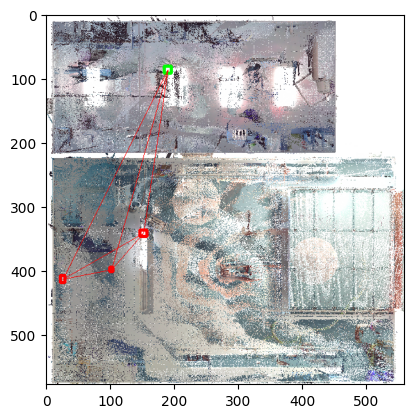

In [27]:
for n in imageNodes:
    print(f'processing {n.name}')
    if len(n.predictions)==0:
        continue
    
    #get point cloud
    f=next((f for f in files if n.name in f), None)
    las=laspy.read(f)
    points=o3d.utility.Vector3dVector(las.xyz)
    
    #get all predictions box center
    n.box_centers=np.array([p['box'].get_center() for p in n.predictions])

    #create point cloud from the box centers
    n.box_centers_pcd=o3d.geometry.PointCloud()
    n.box_centers_pcd.points=o3d.utility.Vector3dVector(n.box_centers)
    n.box_centers_pcd.paint_uniform_color([0,0,1])
                
    
    image=n.resource.copy()

    for p in n.predictions:
        #---------------------AXES FILTER---------------------------------
        #for every prediction, compute the axes between the box center and the nearest 4 points in the point cloud
        #get box center
        box_center=np.array(p['box'].get_center())
        #determine neighbors
        k=10 if len(n.box_centers)>10 else len(n.box_centers)
        indices,distances=gmu.compute_nearest_neighbors(np.array([box_center]), n.box_centers, k)
        indices=indices[0]
        distances=distances[0]
        
        #get candiate points
        candidate_points=n.box_centers[indices]
        
        #compute mesh from the box
        box=o3d.geometry.OrientedBoundingBox.create_from_axis_aligned_bounding_box(p['box'])
        p['mesh']=o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(box)
        p['mesh'].compute_vertex_normals()
        
        #compute the normals of the triangles        
        p['triangle_normals']=np.asarray(p['mesh'].triangle_normals)[::2] 
        
        #compute dotproduct between the candiate axes and the normals of the box. retain the biggest value
        candidate_dotproducts=[]
        for c in candidate_points:
            normalized_c=(box_center-c)/np.linalg.norm(box_center-c)
            candidate_dotproducts.append(np.abs(np.array([np.dot(normalized_c,normal) for normal in p['triangle_normals']])).max())
        candidate_dotproducts=np.array(candidate_dotproducts)

        # compute the axis for every candidate point
        candidate_axes=[]
        for c in candidate_points:
            axis=o3d.geometry.LineSet()
            axis.points=o3d.utility.Vector3dVector(np.vstack([p['box'].get_center(),c]))
            axis.lines=o3d.utility.Vector2iVector(np.array([[0,1]]))
            axis.paint_uniform_color([0,0,1])
            candidate_axes.append(axis)
        p['candidate_axes']=np.array(candidate_axes)
        
        #build mask
        mask=(distances>threshold_distance_min) & (candidate_dotproducts>threshold_angle)  & (distances<threshold_distance_max)        
        inlier_indices=indices[mask]
        
        #boost your own confidence for every axes that comply with the mask
        p['confidence_t1']=0
        for i in inlier_indices:
            p['confidence_t1']+=0.1
        
        #---------------------POINT FILTER---------------------------------
        box_expanded=gmu.expand_box(p['mesh'].get_oriented_bounding_box(),0.1,0.1,0.1)
        #crop the point cloud to the bounding box of the prediction
        pcd_indices = box_expanded.get_point_indices_within_bounding_box(points)
        p['indices']=pcd_indices

        #point count score
        score_point_count=1 if len(pcd_indices)>threshold_point_count else len(pcd_indices)/threshold_point_count
        
        # #height ratio score
        # if len(pcd_indices)>0.1*threshold_point_count:
        #     p25=np.percentile(np.asarray(points)[pcd_indices][:,2],25)
        #     p75=np.percentile(np.asarray(points)[pcd_indices][:,2],75)
        #     # Counting elements in each percentile range
        #     count_25 = sum(i <= p25 for i in np.asarray(points)[pcd_indices][:,2]) # Elements in the first 25%
        #     count_50 = sum(p25 < i <= p75 for i in np.asarray(points)[pcd_indices][:,2]) # Elements in the middle 50%
        #     count_75 = sum(i > p75 for i in np.asarray(points)[pcd_indices][:,2]) # Elements in the last 25%
            
        #     score_height_ratio=count_50/(count_25+count_75) if count_25+count_75>=count_50 else 1 #elements in middle should be equal to top and bottom, if more than it should cap out at 1
        # else:
        #     score_height_ratio=0
        
        # #box dimension score
        x_dim,y_dim,_=p['box'].get_extent()
        # orientedBox=o3d.geometry.OrientedBoundingBox.create_from_points(points)
        # v=1-np.abs(orientedBox.extent[1]/threshol_uv_dimensions-1)
        # w=1-np.abs(orientedBox.extent[2]/threshol_uv_dimensions-1)
        uv_dim_score=1 if x_dim<threshold_dimensions and y_dim<threshold_dimensions else 0
            
        #grid score
        grid_score=1 if p['confidence']>threshold_grid else p['confidence']/threshold_grid
        
        #overall score
        p['score']=uv_dim_score*(weight_threshold_confidence*p['confidence']+weight_threshold_grid*grid_score+weight_threshold_point_count*score_point_count) #+weight_threshold_uv_dim*uv_dim_score#+weight_threshold_height_ratio*score_height_ratio
        print(f"confidence:{p['confidence']}, grid score: {grid_score}, score_point_count pcd inliers: {score_point_count} -> overall score: {p['score']}")

        
        #colorize the candidate axes that do not comply with the mask
        [i.paint_uniform_color([0,1,0]) for i in p['candidate_axes'][mask]]
        
        #colorize image with the axes        
        x = int(p['x']/n.scale)
        y = int(p['y']/n.scale)
        width = int(p['width']/n.scale)
        height = int(p['height']/n.scale)
        cv2.rectangle(image, (int(x-width/2), int(y-height/2)), (int(x + width/2), int(y + height/2)), (0, 255, 0), 3) if p['score']>threshold_score else cv2.rectangle(image, (int(x-width/2), int(y-height/2)), (int(x + width/2), int(y + height/2)), (255, 0, 0), 3)
        #draw the axes
        for i,c in enumerate(p['candidate_axes']):
            p1=(x,y)
            p2=(int(n.predictions[indices[i]]['x']/n.scale),int(n.predictions[indices[i]]['y']/n.scale))
            cv2.line(image, p1, p2, (0, 255, 0), 2) if indices[i] in inlier_indices else cv2.line(image, p1, p2, (255, 0, 0), 1)
            
    plt.imshow(image)
    #write the image to a file
    image_path = results_folder / f'{n.name}_t2.png'
    cv2.imwrite(str(image_path), image)

In [28]:
# joined_pcd=gmu.join_geometries([n.resource.paint_uniform_color(n.color) for n in pcdNodes if n.resource is not None])
# o3d.visualization.draw_geometries([pcd]+[p['box'] for p in n.predictions])

visualize results

In [29]:
# for n in imageNodes[0:1]:
#     joined_axes=gmu.join_geometries([p['candidate_axes'].tolist() for p in n.predictions])
#     #get a slice of the pcd point cloud
#     z_min=pcd.get_center()[2]
#     z_max=z_min+1
#     slice_pcd=t2.slice_point_cloud(pcd, z_min, z_max)
    
#     # candidate_axes=gmu.join_geometries([p['candidate_axes'].tolist() for p in n.predictions])
#     test=[p['candidate_axes'].tolist() for p in n.predictions]
#     candidate_axes=[item for sublist in test for item in sublist]
    

#     for p in n.predictions:
#         #create colorgradient from red to green for the score
#         color=[1-p.score, p.score, 0]
#         p['mesh'].paint_uniform_color(color)
#         if p.score<threshold_score:
#             p['mesh'].paint_uniform_color([0.3,0.3,0.3])

#     meshes=gmu.join_geometries([p['mesh'] for p in n.predictions])
    
#     o3d.visualization.draw_geometries([slice_pcd]+[meshes]+candidate_axes)

## EXPORT RESULTS

assign class labels to point clouds

In [30]:
for n in imageNodes:
    if len(n.predictions)==0:
        continue
    
    #get point cloud
    f=next((f for f in files if n.name in f), None)
    las=laspy.read(f)
    las.point_format.dimension_names
    if 'classes' in list(las.point_format.dimension_names):
        None
    else:
        classArray=np.zeros(las.xyz.shape[0])
        gmu.las_add_extra_dimensions(las,[classArray], ['classes'],dtypes=[np.uint8] )
        
    if 'objects' in list(las.point_format.dimension_names):
        None#objectArray=las['objects']   
    else:
        objectArray=np.zeros(las.xyz.shape[0])
        gmu.las_add_extra_dimensions(las,[objectArray], ['objects'],dtypes=[np.uint16] )
    
    for i,p in enumerate(n.predictions):
        if p['score']>=threshold_confidence:
            #replace classArray[indices] with the class of the prediction ==2
            las.classes[p['indices']]=3
            las.objects[p['indices']]=i+300
    #export las
    las.write(results_folder / f'{n.name}.laz')    